# Generate Synthetic Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
import os

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d")

In [2]:
# Define parameters for the dataset
num_products = 10
num_days = 730  # 2 years of data
start_date = datetime(2022, 1, 1)

# Product categories and their characteristics
product_categories = {
    'Electronics': {'base_price': 100, 'holding_cost': 0.2, 'stockout_cost': 0.5, 'setup_cost': 50, 'lead_time_mean': 7, 'lead_time_std': 2},
    'Clothing': {'base_price': 30, 'holding_cost': 0.15, 'stockout_cost': 0.3, 'setup_cost': 20, 'lead_time_mean': 5, 'lead_time_std': 1},
    'Food': {'base_price': 10, 'holding_cost': 0.25, 'stockout_cost': 0.6, 'setup_cost': 15, 'lead_time_mean': 3, 'lead_time_std': 1},
    'Home Goods': {'base_price': 50, 'holding_cost': 0.18, 'stockout_cost': 0.4, 'setup_cost': 30, 'lead_time_mean': 6, 'lead_time_std': 2}
}

# Create a list to store product information
products = []

# Generate products
for i in range(num_products):
    category = random.choice(list(product_categories.keys()))
    category_params = product_categories[category]
    
    product = {
        'product_id': f'P{i+1:03d}',
        'product_name': f'{category} Item {i+1}',
        'category': category,
        'price': round(category_params['base_price'] * (0.8 + 0.4 * random.random()), 2),  # Random price around base price
        'holding_cost_rate': category_params['holding_cost'] * (0.9 + 0.2 * random.random()),  # Cost to hold inventory as percentage of price
        'stockout_cost_rate': category_params['stockout_cost'] * (0.9 + 0.2 * random.random()),  # Cost of stockouts as percentage of price
        'setup_cost': category_params['setup_cost'] * (0.9 + 0.2 * random.random()),  # Fixed cost for placing an order
        'lead_time_mean': category_params['lead_time_mean'],  # Average lead time in days
        'lead_time_std': category_params['lead_time_std'],  # Standard deviation of lead time
        'seasonal_pattern': random.choice(['none', 'yearly', 'quarterly', 'monthly', 'weekly']),
        'trend_factor': random.choice([-0.2, -0.1, 0, 0.1, 0.2])  # Yearly trend (increase or decrease)
    }
    
    products.append(product)

In [3]:
# Create DataFrame for products
products_df = pd.DataFrame(products)

# Function to generate demand with trend, seasonality, and randomness
def generate_demand(date, product, base_demand=50):
    # Base demand
    demand = base_demand * (0.8 + 0.4 * np.random.random())
    
    # Add trend
    days_since_start = (date - start_date).days
    years_since_start = days_since_start / 365
    demand *= (1 + product['trend_factor'] * years_since_start)
    
    # Add seasonality
    if product['seasonal_pattern'] == 'yearly':
        # Yearly seasonality (higher in summer)
        day_of_year = date.timetuple().tm_yday
        seasonality = np.sin(2 * np.pi * day_of_year / 365)
        demand *= (1 + 0.3 * seasonality)
    elif product['seasonal_pattern'] == 'quarterly':
        # Quarterly seasonality
        month = date.month
        seasonality = np.sin(2 * np.pi * month / 3)
        demand *= (1 + 0.2 * seasonality)
    elif product['seasonal_pattern'] == 'monthly':
        # Monthly seasonality (higher at month beginning)
        day_of_month = date.day
        days_in_month = pd.Timestamp(date).days_in_month
        seasonality = np.sin(2 * np.pi * day_of_month / days_in_month)
        demand *= (1 + 0.15 * seasonality)
    elif product['seasonal_pattern'] == 'weekly':
        # Weekly seasonality (higher on weekends)
        day_of_week = date.weekday()
        seasonality = (1 if day_of_week >= 5 else 0)  # Higher on weekends
        demand *= (1 + 0.25 * seasonality)
    
    # Add randomness (some days have spikes or dips)
    if random.random() < 0.05:  # 5% chance of a significant deviation
        demand *= random.choice([0.5, 0.7, 1.3, 1.5])
    
    # Add a bit of random noise
    demand *= (0.9 + 0.2 * np.random.random())
    
    return max(0, round(demand))

In [4]:
# Create sales data
sales_data = []

for i in range(num_days):
    current_date = start_date + timedelta(days=i)
    
    for product in products:
        # Generate demand for this product on this day
        demand = generate_demand(current_date, product)
        
        # Record the sale
        sale = {
            'date': current_date,
            'product_id': product['product_id'],
            'demand': demand,
            'unit_price': product['price'],
            'total_sales': round(demand * product['price'], 2)
        }
        
        sales_data.append(sale)

# Create DataFrame for sales
sales_df = pd.DataFrame(sales_data)

In [5]:
# Create inventory events data
inventory_events = []
current_inventory = {product['product_id']: 100 for product in products}  # Start with some inventory

for i in range(num_days):
    current_date = start_date + timedelta(days=i)
    
    for product in products:
        product_id = product['product_id']
        
        # Get demand for today
        today_demand = sales_df[(sales_df['date'] == current_date) & 
                               (sales_df['product_id'] == product_id)]['demand'].values[0]
        
        # Calculate actual sales (limited by inventory)
        actual_sales = min(today_demand, current_inventory[product_id])
        stockout = today_demand > current_inventory[product_id]
        
        # Update inventory
        current_inventory[product_id] -= actual_sales
        
        # Random reordering logic (in a real system, this would be optimized)
        if current_inventory[product_id] < 30 or random.random() < 0.05:
            reorder_quantity = random.randint(50, 150)
            lead_time = int(np.random.normal(product['lead_time_mean'], product['lead_time_std']))
            lead_time = max(1, lead_time)  # Ensure lead time is at least 1 day
            delivery_date = current_date + timedelta(days=lead_time)
            
            # Record reorder event
            reorder_event = {
                'date': current_date,
                'product_id': product_id,
                'event_type': 'reorder',
                'quantity': reorder_quantity,
                'expected_delivery': delivery_date,
                'cost': round(product['setup_cost'] + reorder_quantity * product['price'] * 0.7, 2)  # 70% of selling price
            }
            inventory_events.append(reorder_event)
            
            # Schedule the delivery
            delivery_event = {
                'date': delivery_date,
                'product_id': product_id,
                'event_type': 'delivery',
                'quantity': reorder_quantity,
                'expected_delivery': None,
                'cost': 0
            }
            inventory_events.append(delivery_event)
        
        # Record daily inventory level
        inventory_record = {
            'date': current_date,
            'product_id': product_id,
            'event_type': 'inventory',
            'quantity': current_inventory[product_id],
            'expected_delivery': None,
            'cost': round(current_inventory[product_id] * product['price'] * product['holding_cost_rate'] / 365, 2),  # Daily holding cost
            'stockout': stockout,
            'stockout_cost': round((today_demand - actual_sales) * product['price'] * product['stockout_cost_rate'], 2) if stockout else 0
        }
        inventory_events.append(inventory_record)
        
        # Process any deliveries for today
        for event in inventory_events:
            if (event['date'] == current_date and 
                event['product_id'] == product_id and 
                event['event_type'] == 'delivery'):
                current_inventory[product_id] += event['quantity']

# Create DataFrame for inventory events
inventory_df = pd.DataFrame(inventory_events)

Generated 10 products
Generated 7300 sales records
Generated 12742 inventory events

Products Sample:


,product_id,product_name,category,price,holding_cost_rate,stockout_cost_rate,setup_cost,lead_time_mean,lead_time_std,seasonal_pattern,trend_factor
0,P001,Electronics Item 1,Electronics,81.00,0.191001,0.472321,52.364712,7,2,weekly,-0.2
1,P002,Home Goods Item 2,Home Goods,40.64,0.165373,0.378613,30.612112,6,2,weekly,-0.1
2,P003,Home Goods Item 3,Home Goods,44.41,0.183214,0.424754,27.038993,6,2,yearly,0.1
3,P004,Food Item 4,Food,9.11,0.235766,0.631619,13.806631,3,1,monthly,-0.2
4,P005,Food Item 5,Food,11.39,0.255186,0.636855,15.689195,3,1,weekly,-0.2



Sales Sample:


,date,product_id,demand,unit_price,total_sales
0,2022-01-01,P001,65,81.00,5265.00
1,2022-01-01,P002,70,40.64,2844.80
2,2022-01-01,P003,40,44.41,1776.40
3,2022-01-01,P004,59,9.11,537.49
4,2022-01-01,P005,68,11.39,774.52



Inventory Events Sample:


,date,product_id,event_type,quantity,expected_delivery,cost,stockout,stockout_cost
0,2022-01-01,P001,inventory,35,NaT,1.48,False,0.0
1,2022-01-01,P002,inventory,30,NaT,0.55,False,0.0
2,2022-01-01,P003,inventory,60,NaT,1.34,False,0.0
3,2022-01-01,P004,inventory,41,NaT,0.24,False,0.0
4,2022-01-01,P005,inventory,32,NaT,0.25,False,0.0


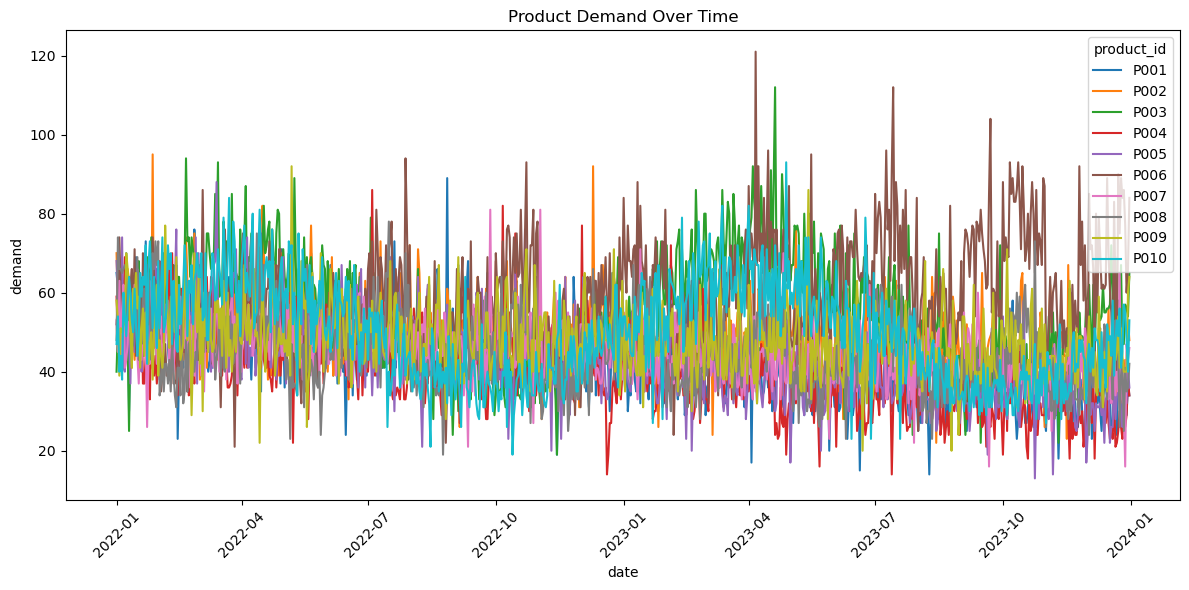

Data generation complete!


In [6]:
# Ensure the data directory exists
if not os.path.exists('../data'):
    os.makedirs('../data')

# Save the DataFrames to CSV files
products_df.to_csv(f'../data/products_{timestamp}.csv', index=False)
sales_df.to_csv(f'../data/sales_{timestamp}.csv', index=False)
inventory_df.to_csv(f'../data/inventory_{timestamp}.csv', index=False)

print(f"Generated {len(products_df)} products")
print(f"Generated {len(sales_df)} sales records")
print(f"Generated {len(inventory_df)} inventory events")

# Display sample of each dataset
print("\nProducts Sample:")
display(products_df.head())

print("\nSales Sample:")
display(sales_df.head())

print("\nInventory Events Sample:")
display(inventory_df.head())

# Generate some basic visualizations
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_df, x='date', y='demand', hue='product_id')
plt.title('Product Demand Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save a categorized version of the combined data for easier analysis
merged_data = sales_df.merge(products_df[['product_id', 'product_name', 'category']], on='product_id')
merged_data.to_csv(f'../data/combined_data_{timestamp}.csv', index=False)

print("Data generation complete!")